In [1]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, cross_val_score
from sklearn.feature_selection import RFE, RFECV, SelectFromModel
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

## Greedy feature selection

In [2]:
# データ準備
df = pd.read_csv('penguins_size.csv')
df.loc[df[df['sex']=='.'].index, 'sex'] = np.nan

In [3]:
# 欠損値確認
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 344 entries, 0 to 343
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   species            344 non-null    object 
 1   island             344 non-null    object 
 2   culmen_length_mm   342 non-null    float64
 3   culmen_depth_mm    342 non-null    float64
 4   flipper_length_mm  342 non-null    float64
 5   body_mass_g        342 non-null    float64
 6   sex                333 non-null    object 
dtypes: float64(4), object(3)
memory usage: 18.9+ KB


In [4]:
# 欠損が多いデータは落とす
df.dropna(thresh=3, inplace=True)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 342 entries, 0 to 343
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   species            342 non-null    object 
 1   island             342 non-null    object 
 2   culmen_length_mm   342 non-null    float64
 3   culmen_depth_mm    342 non-null    float64
 4   flipper_length_mm  342 non-null    float64
 5   body_mass_g        342 non-null    float64
 6   sex                333 non-null    object 
dtypes: float64(4), object(3)
memory usage: 21.4+ KB


In [6]:
# X, y 作成
X = df.drop('species', axis=1)
y = df['species']

# 欠損値代入
imputer = SimpleImputer(strategy='constant', fill_value='NaN')
imputer.set_output(transform='pandas')
# X全体にfit_transformをすると，全てのカラムのDtypeがobjectになってしまい，後続のダミー変数作成の際に全カラムに対してOHEしてしまうため，
# ここではsexカラムを指定して，sexカラムにのみ実施する
X['sex'] = imputer.fit_transform(X[['sex']])

# OHE
class GetDummies(BaseEstimator, TransformerMixin):
    
    def __init__(self):
        self.columns = None
        
    def fit(self, X, y=None):
        self.columns = pd.get_dummies(X).columns
        return self
    
    def transform(self, X):
        X_new = pd.get_dummies(X)
        return X_new.reindex(columns=self.columns, fill_value=0)

# 特徴量エンジニアリング
# 多項式特徴量
poly = PolynomialFeatures(degree=2, include_bias=False)
X[['culmen_length_mm', 'culmen_depth_mm', 'culmen_length_mm^2', 'culmen_length_mm * culmen_depth_mm', 'culmen_depth_mm^2']] = poly.fit_transform(X[['culmen_length_mm', 'culmen_depth_mm']])
# 四則演算
X['culmen_diff'] = X['culmen_length_mm'] - X['culmen_depth_mm']
X['culmen_ratio'] = X['culmen_length_mm'] / X['culmen_depth_mm']

# Pipeline
pipeline = Pipeline([('dummy', GetDummies()),
          ('scaler', StandardScaler()),
          ('model', LogisticRegression())])

# cv
cv = KFold(n_splits=3, random_state=0, shuffle=True)

In [7]:
class GreedyFeatureSelection():
    
    def __init__(self, pipeline, cv):
        self.pipeline = pipeline
        self.cv = cv
        self.selected_features = []
        self.scores = [0]
    
    def select_feature(self, X, y):
        
        all_features = X.columns
        
        while True:
            # print('greedy selection started')
            best_score = self.scores[-1]
            candidate_feature = None
            for feature in all_features:
                if feature in self.selected_features:
                    continue
                # print(f'{feature} started')
                features = self.selected_features + [feature]
                X_train = X[features]
                # 評価
                score = cross_val_score(self.pipeline, X_train, y, cv=self.cv).mean()
                # print(f'{features} score: {score}')
                if score > best_score:
                    # print(f'best score updated {best_score} -> {score}')
                    best_score = score
                    candidate_feature = feature
            
            if candidate_feature is not None:
                # print(f'========{candidate_feature} is selected=============')
                self.scores.append(best_score)
                self.selected_features.append(candidate_feature)
            else:
                break

In [8]:
# Greedy feature selection
gfs = GreedyFeatureSelection(pipeline=pipeline, cv=cv)
gfs.select_feature(X, y)
# スコアの結果と選択された特徴量を確認
print(gfs.scores)
print(gfs.selected_features)

[0, 0.9619883040935672, 0.9912280701754387, 0.9970760233918128, 1.0]
['culmen_ratio', 'island', 'culmen_diff', 'body_mass_g']


## RFE

In [9]:
rfe = RFE(DecisionTreeClassifier(), n_features_to_select=6)
X = pd.get_dummies(X, drop_first=True)
rfe.fit(X, y)
rfe.transform(X)

array([[20.4       ,  2.09090909,  0.        ,  1.        ,  1.        ,
         0.        ],
       [22.1       ,  2.27011494,  0.        ,  1.        ,  0.        ,
         0.        ],
       [22.3       ,  2.23888889,  0.        ,  1.        ,  0.        ,
         0.        ],
       ...,
       [34.7       ,  3.21019108,  0.        ,  0.        ,  1.        ,
         0.        ],
       [30.4       ,  3.05405405,  0.        ,  0.        ,  0.        ,
         0.        ],
       [33.8       ,  3.09937888,  0.        ,  0.        ,  1.        ,
         0.        ]])

In [10]:
# 特徴量の重要度ランキング
rfe.ranking_

array([8, 7, 6, 5, 4, 3, 2, 1, 1, 1, 1, 1, 1])

In [11]:
# 選択された特徴量のリストを取得
# rfe.feature_names_in_[rfe.ranking_==1]
rfe.feature_names_in_[rfe.support_]

array(['culmen_diff', 'culmen_ratio', 'island_Dream', 'island_Torgersen',
       'sex_MALE', 'sex_NaN'], dtype=object)

In [12]:
# Pipelineに組み込む
pipeline = Pipeline([('rfe', rfe), ('scaler', StandardScaler()), ('model', LogisticRegression())])
scores = cross_val_score(pipeline, X, y, cv=cv)
print(scores)

[1.         1.         0.99122807]


In [13]:
# RFECV
rfecv = RFECV(DecisionTreeClassifier(), cv=cv)
rfecv.fit(X, y)
rfecv.transform(X)

array([[20.4       ,  2.09090909,  0.        ],
       [22.1       ,  2.27011494,  0.        ],
       [22.3       ,  2.23888889,  0.        ],
       ...,
       [34.7       ,  3.21019108,  0.        ],
       [30.4       ,  3.05405405,  0.        ],
       [33.8       ,  3.09937888,  0.        ]])

In [14]:
rfecv.feature_names_in_[rfecv.support_]

array(['culmen_diff', 'culmen_ratio', 'island_Dream'], dtype=object)

<ErrorbarContainer object of 3 artists>

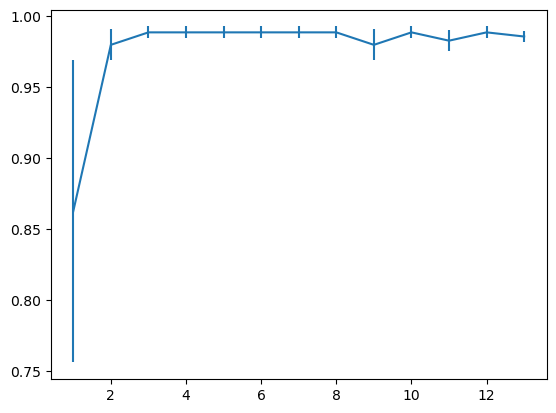

In [15]:
# 特徴量の数と精度の推移を描画
import matplotlib.pyplot as plt
plt.errorbar(range(1, 1+len(rfecv.cv_results_['mean_test_score'])),
            rfecv.cv_results_['mean_test_score'],
            yerr=rfecv.cv_results_['std_test_score'])

## モデルの係数や重要度で特徴量選択

In [16]:
# RandomForestを使って特徴量の重要度が低い特徴量を落とす
sfm = SelectFromModel(RandomForestClassifier(random_state=0))
X_selected = sfm.fit_transform(X, y)
X_selected

array([[ 39.1       ,  18.7       , 181.        , ..., 349.69      ,
         20.4       ,   2.09090909],
       [ 39.5       ,  17.4       , 186.        , ..., 302.76      ,
         22.1       ,   2.27011494],
       [ 40.3       ,  18.        , 195.        , ..., 324.        ,
         22.3       ,   2.23888889],
       ...,
       [ 50.4       ,  15.7       , 222.        , ..., 246.49      ,
         34.7       ,   3.21019108],
       [ 45.2       ,  14.8       , 212.        , ..., 219.04      ,
         30.4       ,   3.05405405],
       [ 49.9       ,  16.1       , 213.        , ..., 259.21      ,
         33.8       ,   3.09937888]])

In [17]:
# .estimator_で特徴量選択に使用したモデルにアクセス
sfm.estimator_.feature_importances_

array([0.08924232, 0.07961904, 0.09933245, 0.0525517 , 0.08072858,
       0.01467092, 0.10925035, 0.14543881, 0.24562145, 0.07424349,
       0.00630753, 0.00299336, 0.        ])

In [18]:
# 選択された特徴量のリストを取得
sfm.feature_names_in_[sfm.get_support()]

array(['culmen_length_mm', 'culmen_depth_mm', 'flipper_length_mm',
       'culmen_length_mm^2', 'culmen_depth_mm^2', 'culmen_diff',
       'culmen_ratio'], dtype=object)

## L1正則化項で特徴量選択

In [19]:
# estimtatorにl1正則を使用するモデルを入れると，l1正則を使って特徴量選択が可能
sfm = SelectFromModel(LogisticRegression(penalty="l1", solver='liblinear'))
pipeline = Pipeline([('scaler', StandardScaler()),
                     ('feature selection', sfm)])
pipeline.set_output(transform='pandas')
pipeline.fit_transform(X, y)

,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,culmen_length_mm * culmen_depth_mm,culmen_depth_mm^2,culmen_diff,culmen_ratio,island_Dream,island_Torgersen,sex_MALE
0,-0.884499,0.785449,-1.418347,-0.564142,-0.170197,0.768371,-1.024588,-1.036429,-0.754193,2.388699,1.017700
1,-0.811126,0.126188,-1.062250,-0.501703,-0.550838,0.070068,-0.751183,-0.675598,-0.754193,2.388699,-0.982607
2,-0.664380,0.430462,-0.421277,-1.188532,-0.220261,0.386112,-0.719018,-0.738471,-0.754193,2.388699,-0.982607
4,-1.324737,1.089724,-0.563715,-0.938776,-0.368543,1.107627,-1.507068,-1.417695,-0.754193,2.388699,-0.982607
5,-0.847812,1.748985,-0.777373,-0.689020,0.510134,1.879435,-1.297994,-1.405186,-0.754193,2.388699,1.017700
...,...,...,...,...,...,...,...,...,...,...,...
338,0.601305,-1.750171,0.931890,0.903175,-0.903628,-1.642135,1.082241,1.690550,-0.754193,-0.418638,-0.982607
340,0.527932,-1.445897,1.003109,0.809516,-0.707537,-1.392157,0.921415,1.343164,-0.754193,-0.418638,-0.982607
341,1.188289,-0.735923,1.501644,1.933419,0.351353,-0.767211,1.275233,1.217248,-0.754193,-0.418638,1.017700
342,0.234440,-1.192335,0.789451,1.246590,-0.709967,-1.175658,0.583679,0.902865,-0.754193,-0.418638,-0.982607


In [20]:
# 使用したロジスティック回帰の係数(3クラス分)を確認
sfm.estimator_.coef_

array([[ 0.        ,  0.        , -0.17837796,  0.        ,  0.        ,
         0.        ,  0.08218938, -6.97592113,  0.        , -0.34900286,
         0.88982087,  1.17944793,  0.        ],
       [ 4.21255667,  0.        ,  0.        , -2.36976069,  0.        ,
         0.14737444,  0.        ,  0.        ,  0.        ,  2.66136579,
         0.        , -0.75593737,  0.        ],
       [ 0.        , -2.75559072,  1.69766816,  1.80788218,  0.        ,
         0.        ,  0.        ,  0.        ,  0.5335975 , -0.25339517,
         0.        ,  0.        ,  0.        ]])

In [21]:
# 選択された特徴量のリスト
sfm.feature_names_in_[sfm.get_support()]

array(['culmen_length_mm', 'culmen_depth_mm', 'flipper_length_mm',
       'body_mass_g', 'culmen_length_mm * culmen_depth_mm',
       'culmen_depth_mm^2', 'culmen_diff', 'culmen_ratio', 'island_Dream',
       'island_Torgersen', 'sex_MALE'], dtype=object)